In [1]:
!wget -O embedder.tflite -q https://storage.googleapis.com/mediapipe-models/image_embedder/mobilenet_v3_small/float32/1/mobilenet_v3_small.tflite

In [2]:
import urllib

IMAGE_FILENAMES = ['burger.jpg', 'burger_crop.jpg']

for name in IMAGE_FILENAMES:
    url = f'https://storage.googleapis.com/mediapipe-assets/{name}'
    urllib.request.urlretrieve(url, name)

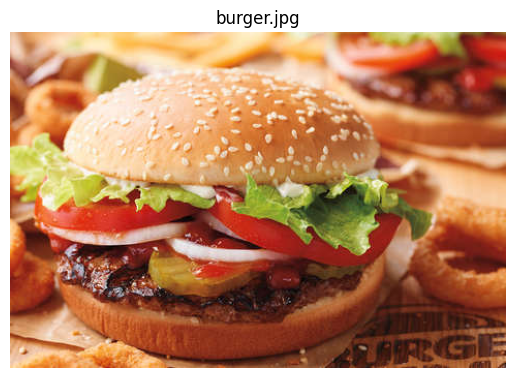

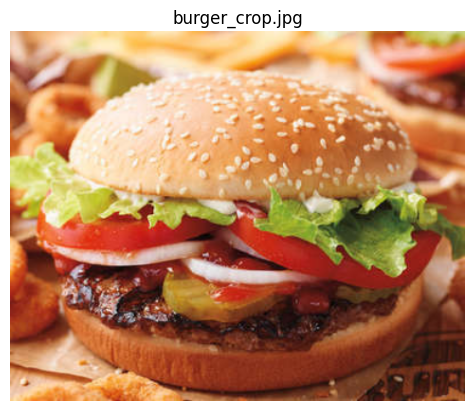

In [3]:
import cv2
import matplotlib.pyplot as plt
import math

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

def resize_and_show(image):
    h, w = image.shape[:2]
    if h < w:
        img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
    else:
        img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
    return img


# Preview the images.
images = {name: cv2.imread(name) for name in IMAGE_FILENAMES}

for name, image in images.items():

    resized_image = resize_and_show(image)

    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.title(name)
    plt.axis('off')
    plt.show()

In [4]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Create options for Image Embedder
base_options = python.BaseOptions(model_asset_path='embedder.tflite')
l2_normalize = True #@param {type:"boolean"}
quantize = True #@param {type:"boolean"}
options = vision.ImageEmbedderOptions(
    base_options=base_options, l2_normalize=l2_normalize, quantize=quantize)


# Create Image Embedder
with vision.ImageEmbedder.create_from_options(options) as embedder:

    # Format images for MediaPipe
    first_image = mp.Image.create_from_file(IMAGE_FILENAMES[0])
    second_image = mp.Image.create_from_file(IMAGE_FILENAMES[1])
    first_embedding_result = embedder.embed(first_image)
    second_embedding_result = embedder.embed(second_image)

    # Calculate and print similarity
    similarity = vision.ImageEmbedder.cosine_similarity(
      first_embedding_result.embeddings[0],
      second_embedding_result.embeddings[0])
    print(similarity)

0.9154104779706991


libEGL warning: DRI3: Screen seems not DRI3 capable
libEGL warning: DRI3: Screen seems not DRI3 capable
MESA: error: ZINK: failed to choose pdev
libEGL warning: egl: failed to create dri2 screen
I0000 00:00:1765153342.480677    1956 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765153342.556514    2048 gl_context.cc:357] GL version: 3.0 (OpenGL ES 3.0 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (Intel(R) UHD Graphics)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/home/haram/miniforge3/envs/mediapipe3/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


# 미디어 파이프 모델로 얼굴 유사도 판별하기
* 사진 2장 필요
* 사진에서 얼굴 찾기 - 얼굴 찾는 모델
* 얼굴만 크롭
* 얼굴을 숫자로 임베딩 - 이미지를 숫자로 벡터화(임베딩)하는 모델
* 임베딩 된 얼굴을 비교
* 유사도 출력
* 간단한 서비스 구현을 위해 gradio라이브러리 활용

# 사진에서 얼굴 추출하는 함수 작성

In [5]:
def crop_face(image_np):
    mp_face_detection = mp.solutions.face_detection
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as detector:
        results = detector.process(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
        if not results.detections:
            return None
        bbox = results.detections[0].location_data.relative_bounding_box
        h, w, _ = image_np.shape
        x_min = int(bbox.xmin * w)
        y_min = int(bbox.ymin * h) 
        width = int(bbox.width * w) 
        height = int(bbox.height * h) 
        return image_np[y_min:y_min + height, x_min:x_min + width]

# 얼굴 유사도 비교 함수 작성

In [6]:
# first_image = mp.Image.create_from_file("./image2.jpg")
# first_image = first_image.numpy_view()
# croped_face1 = crop_face(first_image)
# plt.imshow(first_image)
# plt.show()
# plt.imshow(croped_face1)
# plt.show()

In [7]:
def image_to_text(image1, image2):
    # 이미지가 없는 경우 예외처리
    if image1 is None or image2 is None:
        return "이미지를 두 장 모두 업로드 하세요."
    
    img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    
    # crop_face 함수로 얼굴만 추출해서 저장
    face1 = crop_face(img1)
    face2 = crop_face(img2)

    if face1 is None or face2 is None:
        return "얼굴 감지 실패"
    
    cv2.imwrite("face1.jpg", face1)
    cv2.imwrite("face2.jpg", face2)
    
    # Create options for Image Embedder
    base_options = python.BaseOptions(model_asset_path='./mobilenet_v3_large.tflite')
    options = vision.ImageEmbedderOptions(base_options=base_options, l2_normalize=True, quantize=True)
    
    # Create Image Embedder
    with vision.ImageEmbedder.create_from_options(options) as embedder:

        # Format images for MediaPipe
        first_image = mp.Image.create_from_file("./face1.jpg")
        second_image = mp.Image.create_from_file("./face2.jpg")
        first_embedding_result = embedder.embed(first_image)
        second_embedding_result = embedder.embed(second_image)

        # Calculate and print similarity
        similarity = vision.ImageEmbedder.cosine_similarity(
          first_embedding_result.embeddings[0],
          second_embedding_result.embeddings[0])
        return f"얼굴 유사도: {similarity:.4f}"
    
    

In [8]:
import numpy as np

In [9]:
# first_image = mp.Image.create_from_file("./image1_1.jpg")
# second_image = mp.Image.create_from_file("./image2.jpg")
# image_to_text(first_image, second_image)

# gradio를 이용해서 UI 및 간이 서비스 만들기
* 내부적으로 fastapi를 이용

In [10]:
import gradio as gr

/home/haram/miniforge3/envs/mediapipe3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
with gr.Blocks() as app:
    gr.Markdown("얼굴 유사도 비교")
    with gr.Tab('image Upload'):
        with gr.Row():
            with gr.Column():
                image1 = gr.Image(label="first_image")
            with gr.Column():
                image2 = gr.Image(label="second_image")
    output = gr.Textbox(label="얼굴 유사도: ")
    convert_btn = gr.Button("유사도 비교하기")
    convert_btn.click(
        fn=image_to_text, inputs=[image1, image2], outputs=output)
app.launch(inline=False, share=True)

* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://0afe9b9413b02fa189.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


I0000 00:00:1765153516.840667    2068 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765153516.852665    2101 gl_context.cc:357] GL version: 3.0 (OpenGL ES 3.0 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (Intel(R) UHD Graphics)
W0000 00:00:1765153516.869231    2095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1765153516.896042    2068 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765153516.909511    2110 gl_context.cc:357] GL version: 3.0 (OpenGL ES 3.0 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (Intel(R) UHD Graphics)
W0000 00:00:1765153516.924079    2104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1765153517.896791    2092 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 

In [13]:
app.close()

Closing server running on port: 7861
